In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib notebook

# read data
import cifar_helper

cifar = cifar_helper.CIFAR("./cifar_10_batches_py/")

(12, 32, 32, 3)


<IPython.core.display.Javascript object>


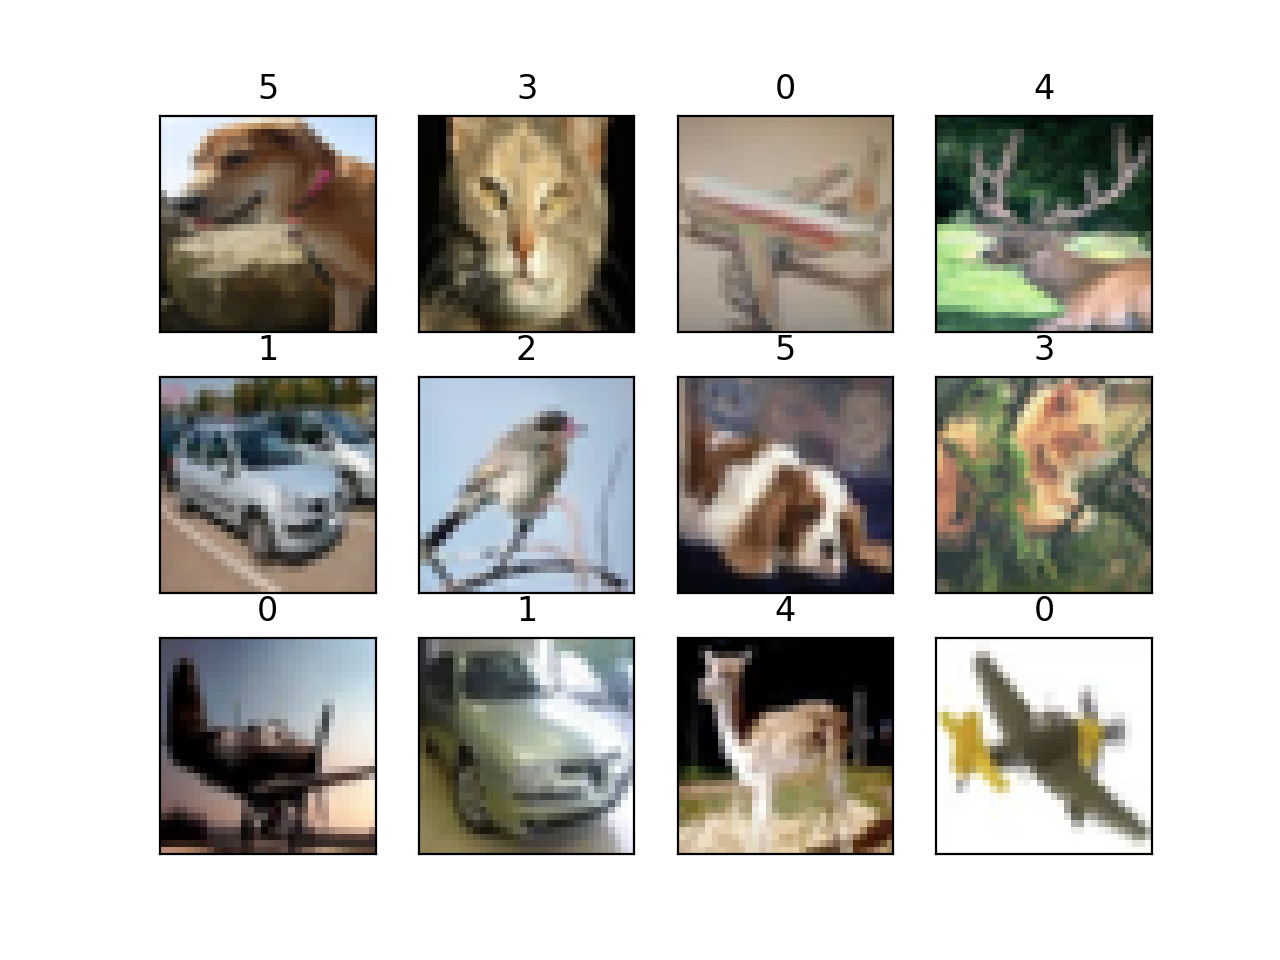

<function matplotlib.pyplot.show>

In [3]:
# size of our mini batch, the amount of samples we train on in each training instance
epochs = 8
mini_batch_size = 200
plot_step_size = 25
training_steps = cifar.get_sizes()[0] // mini_batch_size

# retrieve training batch
images, label = next(cifar.get_training_batch(12))

print(images.shape)

# plot training batch
fig, axes = plt.subplots(3, 4)
for i, ax in enumerate(np.reshape(axes, [-1])):
    ax.imshow(images[i])
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    ax.set_title(label[i])
plt.show

In order to get an idea of the complexity of the network structure, think about the following two questions: How many neurons are simulated? 

There are 16*32*32 + 16*16*16 + 32*16*16 + 32*8*8 + 512 + 10 = 31242 Neurons.

How many degrees of freedom (weights) does the network have? 

16*5*5*3 + 16 + 32*3*3*16 + 32*8*8*512 + 32*8*8 + 512 * 10 + 10

Of many ﬂoating-point operations are necessary for a forward pass of the network? (Write down your answer!)

In [5]:
kernelsize_l1 = 5
kernelsize_l3 = 3

# defining input x as placeholder
x = tf.placeholder(tf.float32, [None, 32, 32, 3])
labels = tf.placeholder(tf.int64, [None])

# LAYER ONE
# defining kernel of layer 1
kernel_l1 = tf.Variable(tf.truncated_normal(shape=(kernelsize_l1, kernelsize_l1, 3, 16), stddev=0.1))

# apply 1st layer convolution
featuremap_l1 = tf.nn.conv2d(x, kernel_l1, strides=[1, 1, 1, 1], padding="SAME")

# define bias layer one
bias_l1 = tf.Variable(tf.truncated_normal(shape=(32, 32, 16), stddev=0.1))

# Calculate neuron outputs by applying the activation function
activation_l1 = tf.nn.tanh(featuremap_l1 + bias_l1)

# LAYER TWO
# apply max pooling to outputs
pooling_l2 = tf.nn.max_pool(activation_l1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")

# LAYER THREE
# defining kernel of layer 3
kernel_l3 = tf.Variable(tf.truncated_normal(shape=(kernelsize_l3, kernelsize_l3, 16, 32), stddev=0.1))

# apply 3rd layer convolution
featuremap_l3 = tf.nn.conv2d(pooling_l2, kernel_l3, strides=[1, 1, 1, 1], padding="SAME")

# define bias layer three
bias_l3 = tf.Variable(tf.truncated_normal(shape=(16, 16, 32), stddev=0.1))

# Calculate neuron outputs by applying the activation function
activation_l3 = tf.nn.tanh(featuremap_l3 + bias_l3)

# LAYER FOUR
# apply max pooling to outputs
pooling_l4 = tf.nn.max_pool(activation_l3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")

# we reshape the feature maps
reshape_l4 = tf.reshape(pooling_l4, (-1, 8*8*32))

# LAYER FIVE
weights_l5 = tf.Variable(tf.truncated_normal(shape=(8*8*32, 512), stddev=0.1))
bias_l5 = tf.Variable(tf.truncated_normal(shape=[512], stddev=0.1))
drive_l5 = tf.nn.tanh(tf.matmul(reshape_l4, weights_l5) + bias_l5)

# LAYER SIX
weights_l6 = tf.Variable(tf.truncated_normal(shape=(512, 10), stddev=0.1))
bias_l6 = tf.Variable(tf.truncated_normal(shape=[10], stddev=0.1))
# output of our NN
y = tf.matmul(drive_l5, weights_l6) + bias_l6
print(y)

# ERROR CALCULATION
cross_entropy = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=labels, logits=y))
optimizer = tf.train.AdamOptimizer(1e-3)
g_v = optimizer.compute_gradients(cross_entropy)
training_step = optimizer.apply_gradients(g_v)

accuracy = tf.equal(tf.argmax(tf.nn.softmax(y), 1), labels)
accuracy = tf.reduce_mean(tf.cast(accuracy, tf.float32))

Tensor("add_7:0", shape=(?, 10), dtype=float32)


In [13]:
train_c_e = []
train_acc = []

val_c_e = []
val_acc = []

#Session
session = tf.Session()
session.run(tf.global_variables_initializer())

# EVALUATION
# Plot initialization
plt.ion()
figs, (ax1, ax2) = plt.subplots(2,1)
plt.title("Evaluation during training...")

total_steps = 0

for epoch in range(epochs):
    print('Epoch Number:', epoch)
    for imgs, lbls in cifar.get_training_batch(mini_batch_size):
        training_cross_entropy, training_accuracy,  _ = session.run(
                    [cross_entropy, accuracy,  training_step],
                    feed_dict={x: imgs, labels: lbls}
                )
        total_steps +=1
        session.run(g_v, feed_dict = {x: imgs, labels: lbls})

        train_c_e.append(training_cross_entropy)
        train_acc.append(training_accuracy)
        

        if total_steps % plot_step_size == 0:
            val_accuracy, val_cross_ent = session.run([accuracy, cross_entropy], 
                        feed_dict={x: cifar._validation_data, labels: cifar._validation_labels})
            print(val_accuracy)
            val_c_e.append(val_cross_ent)
            val_acc.append(val_accuracy)
            
            plt.sca(ax1)
            ax1.cla()
            plt.sca(ax2)
            ax2.cla()

            ax1.plot(range(0, total_steps), train_c_e, 'b-')
            ax1.set_ylabel('Cross Entropy {:1.3f}'.format(train_c_e[-1]))
            ax1.set_xlabel('Training step {:d}'.format(total_steps))
            ax1.legend()

            ax2.plot(range(0, total_steps), train_acc, 'b-')
            ax2.set_ylabel('Accuracy {:1.3f}'.format(train_acc[-1]))
            ax2.set_xlabel('Training step {:d}'.format(total_steps))
            ax2.legend()

            ax1.plot(range(0, total_steps, plot_step_size), val_c_e, 'o', c='orange')
            ax1.set_ylabel('Cross Entropy {:1.3f}'.format(val_c_e[-1]))
            ax1.set_xlabel('Trainingsstep {:d}'.format(total_steps))

            ax2.plot(range(0, total_steps, plot_step_size), val_acc, 'o', c='orange')
            ax2.set_ylabel(('Accuracy {:1.3f}'.format(val_acc[-1])))
            ax2.set_xlabel('Trainingstep {:d}'.format(total_steps))

        figs.canvas.draw()

plt.ioff()
plt.title('Evaluation during training completed')
plt.show()

<IPython.core.display.Javascript object>

Epoch Number: 0


TypeError: Fetch argument None has invalid type <class 'NoneType'>